# Feature Engineering

In [1]:
import pandas as pd
import numpy as np

from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load dataframe
# loans = pd.read_csv('./data/accepted_imputed.csv', low_memory=False)
loans = pd.read_csv('./data/final.df.csv', low_memory=False)

# loans = loans.assign(issue_d=pd.to_datetime(loans['issue_d'], format='%Y-%m-%d'))

loans = loans[(loans['loan_status'] == 'Fully Paid') | (loans['loan_status'] == 'Charged Off') | (loans['loan_status'] == 'Default')]
loans = loans.assign(paid_flag = np.where(loans['loan_status'].str.contains('Fully Paid'), 1, 0))

loans = loans.drop(['loan_status', 'last_fico_range_high', 'last_fico_range_low', 'policy_code'], axis=1) # it depends on loan_status

In [3]:
# under sampling
# loans_paid = loans[loans['paid_flag'] == 1].sample(int(len(loans) * 0.2))
# loans_default = loans[loans['paid_flag'] == 0]

# loans = pd.concat([loans_paid, loans_default])
loans['paid_flag'].value_counts()

1    107725
0     92275
Name: paid_flag, dtype: int64

In [4]:
# select only numeric variables
target_col = []
col_null_cnt = loans.isnull().sum().sort_values(ascending=False)
for k, v in col_null_cnt.iteritems():
    if v == 0:
        if is_numeric_dtype(loans[k].dtype) and k != 'paid_flag':
            target_col = target_col + [k]

target = loans['paid_flag']
# loans = loans[target_col]

In [5]:
# dummify
loans = pd.get_dummies(loans, drop_first=True)

# Modeling

### 1. Logistic Regression

In [6]:
# seprate training & test set        
X_train, X_test, Y_train, Y_test = train_test_split(preprocessing.normalize(loans), target, shuffle=True, test_size=0.2)

logit = linear_model.LogisticRegression(solver='liblinear')

param = dict(C=np.logspace(0, 4, 10), penalty=['l1', 'l2'])

logit_grid = GridSearchCV(logit, param, cv=5, verbose=0)

best_mdl = logit_grid.fit(X_train, Y_train)

# best hyperparameter
print('best hyperparameter')
print('C: ' + str(best_mdl.best_estimator_.get_params()['C']))
print('penalty: ' + best_mdl.best_estimator_.get_params()['penalty'])
print()

# best cross-validation score
print('best cross-validation score: ' + str(best_mdl.score(X_train, Y_train)))

Y_pred = logit_grid.predict(X_test)

best hyperparameter
C: 3593.813663804626
penalty: l1

best cross-validation score: 0.9955


In [7]:
rmse = sqrt(mean_squared_error(Y_test, Y_pred))

print('Root Mean Square Error: ' + str(rmse))
print()

print('Accuracy: ' + str(np.mean(Y_test == Y_pred)))
print()

print(confusion_matrix(Y_test, Y_pred))

Root Mean Square Error: 0.06726812023536856

Accuracy: 0.995475

[[18226   145]
 [   36 21593]]


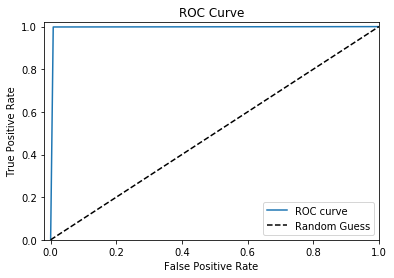

In [8]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)

# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.legend(loc='lower right')